In [1]:
#!pip install langchain_community langchainhub chromadb langchain langgraph tavily-python langchain-text-splitters langchain_openai

# 환경 설정

In [2]:
## openai 키 설정
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [3]:
## tavily 키 설정

import getpass

tavily_key = getpass.getpass("Tavily 키: ")

# LLM 생성

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature = 0)

In [5]:
### Index

from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding = OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = vectorstore.as_retriever()

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

### Generate


system = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n context: {context} "),
    ]
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "What is prompt?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

### Retrieval Grader
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n document: {document} "),
    ]
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "What is prompt?"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

### Answer Grader

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

system = """You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n answer: {generation} "),
    ]
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

### Hallucination Grader

system = """You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "documents: {documents}\n\n answer: {generation} "),
    ]
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})



A prompt is a sequence of tokens designed to increase the likelihood of generating a desired output from a language model. It serves as a way to communicate with the model without altering its weights, focusing on steering its behavior for specific outcomes. Prompt engineering involves experimenting with different prompts to optimize their effectiveness across various models.
{'score': 'yes'}


{'score': 'yes'}

In [7]:
from pprint import pprint
from typing import List

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph

### State


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]
    failed_rel_check: bool
    failed_hal_check: bool

In [8]:
### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print(question)
    print(documents)
    return {"documents": documents, "question": question, "failed_rel_check": False}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation, "failed_hal_check": False}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    failed_relevance_check = state["failed_rel_check"]

    # Score each doc
    filtered_docs = []
    web_search = "Yes"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
            web_search = "No"
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            continue
    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        if failed_relevance_check == True:
            return {"documents": filtered_docs, "question": question, "web_search": web_search, "failed_rel_check": True}
    return {"documents": filtered_docs, "question": question, "web_search": web_search, "failed_rel_check": False}


def hallucination_checker(state):
    """
    hallucination 검사
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        state["hallucinated"] = False
        return state
    else:
        state["hallucinated"] = True
        if state["failed_hal_check"] == True:
            return state
        state["failed_hal_check"] = True
        return state


from tavily import TavilyClient
tavily = TavilyClient(api_key=tavily_key)

def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    print(state)
    question = state["question"]
    documents = None
    if "documents" in state:
      documents = state["documents"]

    # Web search
    docs = tavily.search(query=question)['results']
#    [{'title': 'Where will Lionel Messi play in 2024? Cities, stadiums Inter Miami ...', 'url': 'https://www.sportingnews.com/us/soccer/news/where-lionel-messi-play-2024-inter-miami-cities-road-schedule/23334c5768cebee9021e71d0', 'content': "Here is how Inter Miami's road schedule will look for the coming regular season:\nInter Miami home stadium for 2024 MLS season\nFor their home matches through the 2024 campaign, Inter Miami will once again play at\xa0DRV PNK Stadium in Fort Lauderdale, Florida.\n Cities, stadiums Inter Miami visit on road MLS schedule for new season\nWith Lionel Messi set to embark on his first full season with Inter Miami, fans across the United States will be clamoring to see when the Argentine superstar will visit their city in 2024.\n MLS Season Pass is separate from Apple TV+, meaning those with Apple TV+ would still need an MLS Season Pass subscription to access the complete slate of games, while those without Apple TV+ can still sign up for MLS Season Pass without needing a full Apple TV+ subscription.\n SUBSCRIBE TO MLS SEASON PASS NOW\nApple TV is the official home of the MLS regular season and playoffs, with every match for every team available to stream around the world with no blackouts. How to watch Inter Miami in 2024 MLS season\nLast season, Major League Soccer kicked off a 10-year broadcast rights deal with Apple that sees every single match for the next decade streamed exclusively on Apple's streaming platform.\n", 'score': 0.98612, 'raw_content': None}, {'title': 'Is Lionel Messi playing today? Status for next Inter Miami game in 2024 ...', 'url': 'https://www.sportingnews.com/us/soccer/news/lionel-messi-playing-today-inter-miami-game-2024/129c2c378fee4d1f0102aa9d', 'content': '* Lionel Messi did not participate. Inter Miami schedule for Leagues Cup. The 2024 Leagues Cup is scheduled to begin on July 26, running for a month while the MLS season pauses play.. The final ...', 'score': 0.98209, 'raw_content': None}, {'title': 'Lionel Messi joins Inter Miami: Schedule, MLS tickets to see him play', 'url': 'https://www.usatoday.com/story/sports/mls/2023/06/07/lionel-messi-inter-miami-schedule-tickets/70299298007/', 'content': 'Lionel Messi joins Inter Miami: Full schedule, MLS tickets to see Messi play in US\nLionel Messi\xa0is taking his talents to South Beach.\nMessi,\xa0the 2022 World Cup champion, announced on Wednesday that he will join Major League Soccer\'s Inter Miami CF, a pro soccer club owned by David Beckham, after exiting Ligue 1\'s Paris Saint-Germain following two seasons.\n Tickets to Inter Miami\'s game on June 10 range from $40-$55, but the price tag to see Inter Miami play LigaMX\'s Cruz Azul on July 21 soared to $495 in anticipation of what\'s expected to be Messi\'s first home game, TicketSmarter CEO Jeff Goodman told USA TODAY Sports.\n Each team will play a minimum of two games in the group stage, similar to the World Cup format, with the possibility of more games if the team advances to the knockout rounds.\n "\nAccording to Goodman, nearly 2,000 Inter Miami tickets sold on TicketSmarter the day of Messi\'s announcement Wednesday, compared to under 50 tickets being sold on the platform over the weekend.\n If the Barcelona thing didn\'t work out, I wanted to leave Europe, get out of the spotlight and think more of my family.', 'score': 0.97895, 'raw_content': None}, {'title': "Lionel Messi's 2023 Inter Miami schedule: Every match in MLS, Leagues ...", 'url': 'https://www.sportingnews.com/us/soccer/news/lionel-messi-2023-inter-miami-schedule/d3buao2mhfp7uculkdz3nsc4', 'content': "MORE:\xa0Trophies that Lionel Messi can win with Inter Miami in USA\nLeagues Cup\nIn his first three matches with Inter Miami, Lionel Messi lifted the club into the Leagues Cup Round of 16 thanks to three straight home wins that he helped orchestrate.\n Edition\nLionel Messi's 2023 Inter Miami schedule: Every match in MLS, Leagues Cup and U.S. Open Cup\nLionel Messi is taking North America by storm after scoring in his first three matches for his new club Inter Miami CF.\n MORE: Messi's Miami apartment | Messi's wife & family | Messi's net worth\nLionel Messi, Inter Miami 2023 schedule\nBelow are the remaining games for Inter Miami that Messi will be a part of. MLS\nAfter the Leagues Cup is out of the way, Inter Miami will have 12 MLS matchdays left in a bid to reach the MLS Cup playoffs.\n Inter Miami can still make MLS playoffs\xa0with Lionel Messi\nU.S. Open Cup\nInter Miami reached the semifinal of the competition before Messi and friends joined.", 'score': 0.97298, 'raw_content': None}, {'title': 'Messi, Argentina to play in Chicago, DC before Copa America: More info', 'url': 'https://www.usatoday.com/story/sports/soccer/2024/05/20/messi-argentina-to-play-in-chicago-dc-before-copa-america-more-info/73770204007/', 'content': "1:00. World Cup champion Lionel Messi will participate in two Argentina friendlies early next month before Copa América begins June 20. Messi was officially named to Argentina's 29-man roster ...", 'score': 0.97096, 'raw_content': None}]
#
#
    web_results = []
    for d in docs:
         web_results.append(Document(page_content=d["content"], metadata={"title": d["title"], "source": d["url"]}))
#
#    web_results = "\n".join([d["content"] for d in docs])
#    web_results = Document(page_content=web_results)
#    if documents is not None:
#        documents.append(web_results)
#    else:
#        documents = [web_results]
    return {"documents": web_results, "question": question, "failed_rel_check": state["failed_rel_check"]}

def answer_result(state):
    """
    Final answer node.
    """
    print("---ANSWER---")
    answer = state["generation"]
    documents = state["documents"]

    # Print the final answer and sources
    print(f"Final Answer: {answer}")
    print("Sources:")
    for doc in documents:
        title = doc.metadata.get("title", "N/A")
        url = doc.metadata.get("source", "N/A")
        print(f"- Title: {title}, URL: {url}")

    # Return the state with the final answer and documents
    return {"generation": answer, "documents": documents}


def not_relevant(state):
    """
        재검색 후에도 relevance 검사 실패

    Args:
        state (dict): The current graph state

    """
    print(f"failed: not relevant")
    return state

def hallucinated(state):
    """
        환각 응답을 재생성한 후 검사했는데 또 실패
    """
    print(f"failed: hallucinateion")
    return state

In [9]:
### Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        if state["failed_rel_check"] == True:
             return "failed_check"
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"




In [10]:
### Conditional edge


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        if state["failed_hal_check"] == True:
            return "hallucinated"
        state["failed_hal_check"] = True
        return "not supported"




In [11]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("hallucinate_checker", hallucination_checker)
workflow.add_node("not_relevant", not_relevant)
workflow.add_node("hallucinated", hallucinated)
workflow.add_node("answer", answer_result)

In [12]:
# Build graph
workflow.set_entry_point(
    "retrieve"
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "failed_check": "not_relevant",
        "generate": "generate"
    },
)
workflow.add_edge("websearch", "grade_documents")
workflow.add_edge("generate", "hallucinate_checker")

workflow.add_conditional_edges(
    "hallucinate_checker",
    grade_generation_v_documents_and_question,
    {
        "useful": "answer",
        "hallucinated": "hallucinated",
        "not supported": "generate"
    },
)
workflow.add_edge("not_relevant", END)
workflow.add_edge("hallucinated", END)
workflow.add_edge("answer", END)

In [13]:
# Compile
app = workflow.compile()


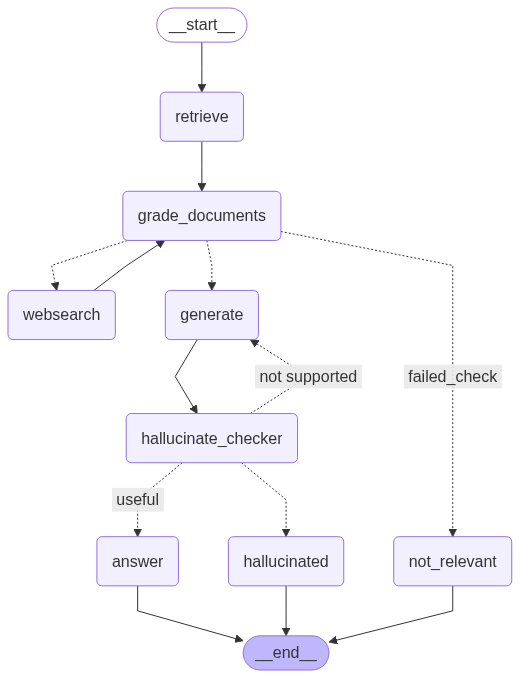

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [20]:
inputs = {"question": "Who is trumph?"}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
Who is trumph?
[Document(metadata={'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/', 'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is quite relevant to this topic, as attacking LLMs is essentially to control the model to output a certain type of (unsafe) content.', 'titl

In [16]:
inputs = {"question": "What is prompt?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
What is prompt?
[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'title': "Prompt Engineering | Lil'Log", 'language': 'en'}, page_content='Automatic Prompt Design#\nPrompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore